In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Verifica si tienes una GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando el dispositivo:", device)

Usando el dispositivo: cuda


In [3]:
# Normalizar las imagenes
transform = transforms.Compose([
    transforms.Resize((288, 432)),  # Por las dudas, todas las imagenes con el mismo tamaño
    transforms.ToTensor(),  # Convertir las imágenes a tensores
])

# Cargar el dataset usando ImageFolder
dataset = datasets.ImageFolder(root='gtzan/images_original', transform=transform)

# Obtener las etiquetas del dataset
labels = [sample[1] for sample in dataset]

# Dividir el dataset en 80% para entrenamiento y 20% para validación, de manera estratificada
train_indices, val_indices = train_test_split(
    range(len(dataset)),
    test_size=0.2,
    stratify=labels,  # Asegura que la división sea por labels (estratificada)
    random_state=42
)

# Crear los datasets de entrenamiento y validación utilizando los índices obtenidos
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

# Cargar los datos en batches
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Modelo base

In [4]:
# Imagen de 288x432
class BaseCNN(nn.Module):
    def __init__(self):
        super(BaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3,
                               padding=1)  # 3 canales RGB, 16 filtros de 3x3, con padding 1 el tamaño de la imagen no cambia
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3,
                               padding=1)  # 16 canales de entrada, 32 filtros de 3x3, con padding 1 el tamaño de la imagen no cambia
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling de 2x2, reduce la imagen a la mitad
        self.fc1 = nn.Linear(32 * 72 * 108, 128)  # 32 canales de 72x108, 128 neuronas en la capa oculta
        self.fc2 = nn.Linear(128, len(dataset.classes))  # 128 neuronas de la capa oculta al número de clases

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # ReLU en la capa convolucional 1 y max pooling, imagen de 144x216
        x = self.pool(torch.relu(self.conv2(x)))  # ReLU en la capa convolucional 2 y max pooling, imagen de 72x108
        x = x.view(-1, 32 * 72 * 108)  # Redimensionar para la capa totalmente conectada
        x = torch.relu(self.fc1(x))  # ReLU en la capa oculta de la red neuronal totalmente conectada
        x = self.fc2(x)  # Capa de salida
        return x

In [5]:
model = BaseCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()  # Guardar el stop loss

        # Accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return running_loss / len(loader), accuracy

In [6]:
# Validación
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()  # Guardar el stop loss

            # Accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return running_loss / len(loader), accuracy

In [7]:
num_epochs = 30
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(
        f"Epoch {epoch + 1}/{num_epochs}, training stop loss: {train_loss:.4f}, training accuracy: {train_acc:.2f}%, validation stop loss: {val_loss:.4f}, validation accuracy: {val_acc:.2f}%")

Epoch 1/30, training stop loss: 3.0671, training accuracy: 12.14%, validation stop loss: 2.2791, validation accuracy: 10.00%
Epoch 2/30, training stop loss: 2.1633, training accuracy: 20.28%, validation stop loss: 2.0929, validation accuracy: 28.50%
Epoch 3/30, training stop loss: 1.8672, training accuracy: 30.66%, validation stop loss: 1.8325, validation accuracy: 36.50%
Epoch 4/30, training stop loss: 1.4352, training accuracy: 51.44%, validation stop loss: 1.5756, validation accuracy: 44.50%
Epoch 5/30, training stop loss: 0.9859, training accuracy: 70.09%, validation stop loss: 1.3906, validation accuracy: 53.50%
Epoch 6/30, training stop loss: 0.5867, training accuracy: 84.98%, validation stop loss: 1.2697, validation accuracy: 56.50%
Epoch 7/30, training stop loss: 0.3144, training accuracy: 92.37%, validation stop loss: 1.2020, validation accuracy: 61.50%
Epoch 8/30, training stop loss: 0.0892, training accuracy: 99.25%, validation stop loss: 1.4153, validation accuracy: 57.50%


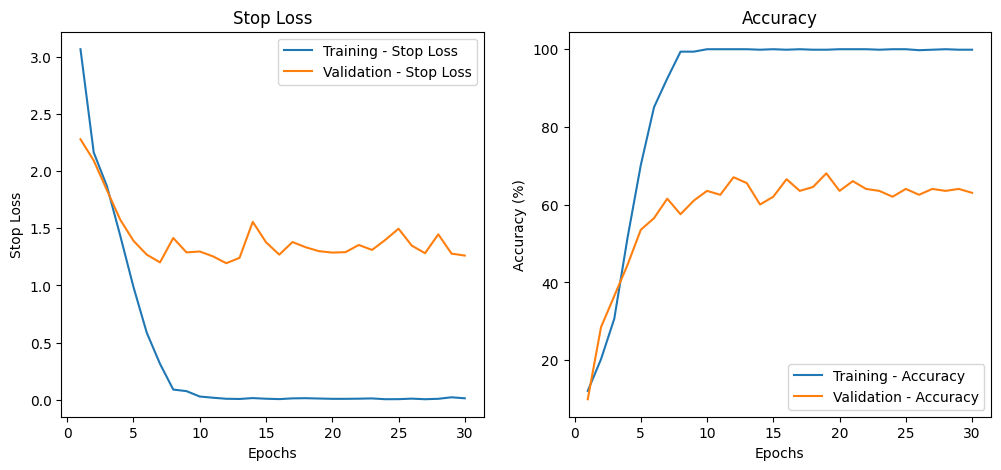

In [8]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training - Stop Loss')
plt.plot(epochs, val_losses, label='Validation - Stop Loss')
plt.xlabel('Epochs')
plt.ylabel('Stop Loss')
plt.legend()
plt.title('Stop Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training - Accuracy')
plt.plot(epochs, val_accuracies, label='Validation - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy')

plt.show()

### Modelo complejo

In [9]:
class ComplexCNN(nn.Module):
    def __init__(self):
        super(ComplexCNN, self).__init__()
        # Capa convolucional 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # 3 canales RGB de entrada, 32 filtros, kernel 3x3, padding 1, salida de 288x432
        self.bn1 = nn.BatchNorm2d(32) # Normalización por lotes

        # Capa convulucional 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 32 filtros de entrada, 64 filtros de salida, kernel 3x3, padding 1, salida de 144x216
        self.bn2 = nn.BatchNorm2d(64) # Normalización por lotes

        # Capa convulacional 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 64 filtros de entrada, 128 filtros de salida, kernel 3x3, padding 1, salida de 72x108
        self.bn3 = nn.BatchNorm2d(128) # Normalización por lotes

        # Capa convulacional 4
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # 128 filtros de entrada, 256 filtros de salida, kernel 3x3, padding 1, salida de 36x54
        self.bn4 = nn.BatchNorm2d(256) # Normalización por lotes

        # Max pooling, reduce la imagen a la mitad        
        self.pool = nn.MaxPool2d(2, 2)

        # Capa totalmente conectada
        self.fc1 = nn.Linear(256 * 18 * 27, 512) # 124416 -> 512
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, len(dataset.classes))

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x)))) # 3 canales RGB de entrada, 32 filtros, kernel 3x3, padding 1, max pooling, salida de 144x216
        x = self.pool(torch.relu(self.bn2(self.conv2(x)))) # 32 filtros de entrada, 64 filtros de salida, kernel 3x3, padding 1, max pooling, salida de 72x108
        x = self.pool(torch.relu(self.bn3(self.conv3(x)))) # 64 filtros de entrada, 128 filtros de salida, kernel 3x3, padding 1, max pooling, salida de 36x54
        x = self.pool(torch.relu(self.bn4(self.conv4(x)))) # 128 filtros de entrada, 256 filtros de salida, kernel 3x3, padding 1, max pooling, salida de 18x27

        x = x.view(x.size(0), -1) # [256, 18, 27] -> [124416]
        x = torch.relu(self.fc1(x)) # 124416 -> 512
        x = self.dropout(x) # Dropout
        x = self.fc2(x) # 512 -> número de clases
        return x

In [10]:
model = ComplexCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return running_loss / len(loader), accuracy

In [11]:
# Validación
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()  # Guardar el stop loss

            # Accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return running_loss / len(loader), accuracy

In [12]:
num_epochs = 1000
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(
        f"Epoch {epoch + 1}/{num_epochs}, training stop loss: {train_loss:.4f}, training accuracy: {train_acc:.2f}%, validation stop loss: {val_loss:.4f}, validation accuracy: {val_acc:.2f}%")

Epoch 1/1000, training stop loss: 29.0570, training accuracy: 14.77%, validation stop loss: 2.6891, validation accuracy: 17.50%
Epoch 2/1000, training stop loss: 2.3800, training accuracy: 15.64%, validation stop loss: 2.2667, validation accuracy: 20.50%
Epoch 3/1000, training stop loss: 2.2272, training accuracy: 16.77%, validation stop loss: 2.2807, validation accuracy: 19.50%
Epoch 4/1000, training stop loss: 2.2214, training accuracy: 16.40%, validation stop loss: 2.3871, validation accuracy: 14.00%
Epoch 5/1000, training stop loss: 2.2017, training accuracy: 16.02%, validation stop loss: 2.2783, validation accuracy: 23.00%
Epoch 6/1000, training stop loss: 2.1753, training accuracy: 17.90%, validation stop loss: 2.3299, validation accuracy: 21.50%
Epoch 7/1000, training stop loss: 2.1904, training accuracy: 17.77%, validation stop loss: 2.3015, validation accuracy: 23.50%
Epoch 8/1000, training stop loss: 2.1482, training accuracy: 19.15%, validation stop loss: 2.3532, validation 

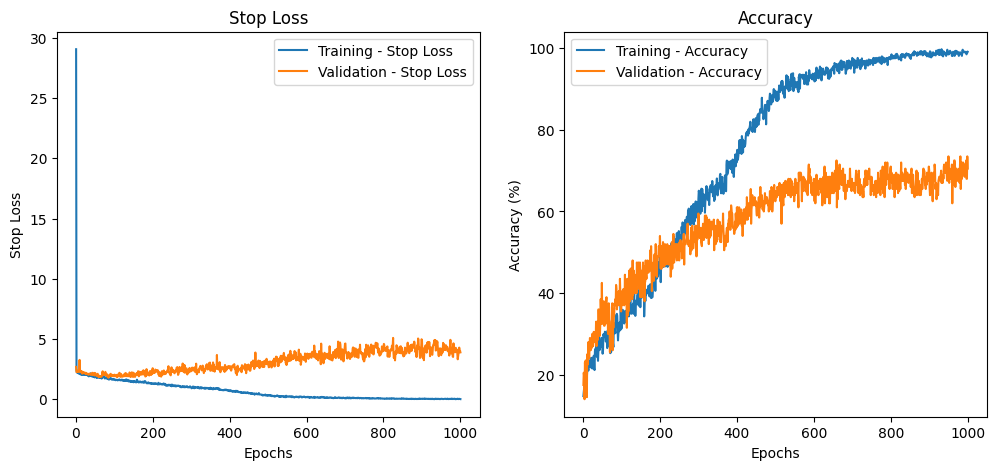

In [13]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training - Stop Loss')
plt.plot(epochs, val_losses, label='Validation - Stop Loss')
plt.xlabel('Epochs')
plt.ylabel('Stop Loss')
plt.legend()
plt.title('Stop Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training - Accuracy')
plt.plot(epochs, val_accuracies, label='Validation - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy')

plt.show()

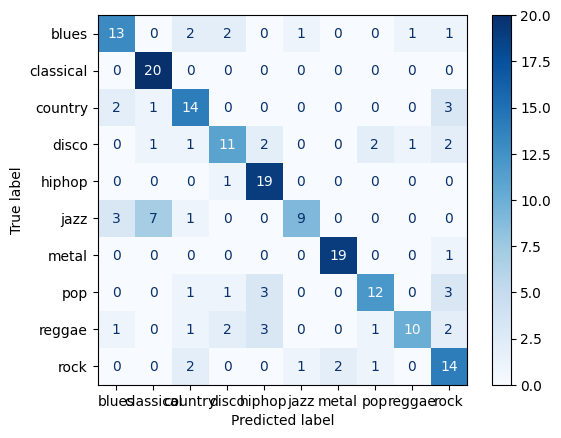

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

model.eval()
with torch.inference_mode():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generar la matriz de confusión
cm = confusion_matrix(all_labels, all_preds)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap='Blues')
plt.show()